In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# The following code is for random generation of colors.
# See here: https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np

    np.random.seed(seed=10)
    np.random.RandomState(seed=10)

    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.graphml','graphml',' ')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh_coordinates.xy', dtype = 'str')

temp = []
for i in ld_coord:
    temp.append(i[0])

idxs = dict(zip(temp, range(len(temp)))) 

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
groups = np.loadtxt('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.class', dtype = 'float')
feature_list = [groups]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 100:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_sfld', ref_nodes) 
            np.save('results/info_ref_nodes_sfld', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 0 Feature value  22.0  gap  [0.91796738]  volume:  16209.0  size: 100 conductance:  0.42254370102471367


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [7]:
ref_nodes = np.load('results/ref_nodes_sfld.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_sfld.npy') 

## Visualize the ground truth clusters

In [8]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
    
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("vector<double>")

c_map = rand_cmap(n, type='bright', first_color_black=False, last_color_black=False, verbose=False)

for i in range(n):
    node_colours[i] = [0,0,0]

counter = 0

for i in ref_nodes:
    
    for j in i:
        node_colours[j] = c_map(int(info_ref_nodes[counter,1]))
    counter += 1

#def get_cmap(n, name='hsv'):
#    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#    RGB color; the keyword argument name must be a standard mpl colormap name.'''
#    return plt.cm.get_cmap(name, n)

#c_map = get_cmap(g_gtool.num_vertices())

#c_map = rand_cmap(n, type='bright', first_color_black=True, last_color_black=False, verbose=True)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.05],
           #vcmap = c_map
           output='sfld_selected.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13cc85438, at 0x13cc72da0>

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [9]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            rho = 0.2/sum(g.d[rr])
            
            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=rho,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                if len(S_l1pr) == 1:
                    S_smqi_val = 1
                else:
                    S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                    S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                if len(S_l1pr) == 1:
                    S_smqi_val = 1
                else:
                    S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                    S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_sfld', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_sfld', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_sfld', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_sfld', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_sfld', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_sfld', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_sfld', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_sfld', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_sfld', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_sfld', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_sfld', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_sfld', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_sfld', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_sfld', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_sfld', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_sfld', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_sfld', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_sfld', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_sfld', cuts_acl_ALL) 
    
    np.save('results/nodes_sfld', nodes)

50
outer: 0 number of node:  51  completed:  0.0  degree:  157.0
conductance:  0.4126234435379991 f1score:  0.8243996097069655 precision:  0.8415370774964658 recall:  0.8079462027268801
outer: 0 number of node:  109  completed:  0.02  degree:  174.0
conductance:  0.4398547435315479 f1score:  0.718070260931201 precision:  0.5601479075232402 recall:  1.0
outer: 0 number of node:  130  completed:  0.04  degree:  170.0
conductance:  0.4683935820606998 f1score:  0.7535300050428644 precision:  0.770281590308654 recall:  0.7374915170584243
outer: 0 number of node:  83  completed:  0.06  degree:  148.0
conductance:  0.4265454779862051 f1score:  0.8759266239477322 precision:  0.892237793562424 recall:  0.860201122832994
outer: 0 number of node:  117  completed:  0.08  degree:  163.0
conductance:  0.45757243337420145 f1score:  0.780924274770815 precision:  0.795052099980822 recall:  0.7672897772842248
outer: 0 number of node:  55  completed:  0.1  degree:  159.0
conductance:  0.4126234435379991 

outer: 0 number of node:  20  completed:  0.92  degree:  181.0
conductance:  0.49607515120319134 f1score:  0.6596957576139334 precision:  0.6738514991635568 recall:  0.6461225245234129
outer: 0 number of node:  124  completed:  0.94  degree:  172.0
conductance:  0.46748308088946183 f1score:  0.7308538041088144 precision:  0.744512 recall:  0.7176877043617743
outer: 0 number of node:  61  completed:  0.96  degree:  155.0
conductance:  0.4220264317180617 f1score:  0.8532982026912581 precision:  0.8679173047473201 recall:  0.8391634277253378
outer: 0 number of node:  69  completed:  0.98  degree:  152.0
conductance:  0.4209104938271605 f1score:  0.8886999779603917 precision:  0.90747170781893 recall:  0.870689123326547


## Improve the results found by the spectral algorithm using MQI

In [10]:
nodes = np.load('results/nodes_sfld.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_sfld.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_mqi_sfld', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_mqi_sfld', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_mqi_sfld', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_mqi_sfld', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_mqi_sfld', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_mqi_sfld', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_mqi_sfld', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_mqi_sfld', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_mqi_sfld', f1score_acl_flow) 

50
outer: 0 number of node:  51  completed:  0.0  degree:  157.0
conductance:  0.438118493766868 f1score:  0.8243996097069655 precision:  0.8415370774964658 recall:  0.8079462027268801
outer: 0 number of node:  109  completed:  0.02  degree:  174.0
conductance:  0.4126234435379991 f1score:  0.7200799644602399 precision:  0.5625976189649786 recall:  1.0
outer: 0 number of node:  130  completed:  0.04  degree:  170.0
conductance:  0.46773250146227335 f1score:  0.7566780605139891 precision:  0.7768895821147722 recall:  0.7374915170584243
outer: 0 number of node:  83  completed:  0.06  degree:  148.0
conductance:  0.4265454779862051 f1score:  0.8759266239477322 precision:  0.892237793562424 recall:  0.860201122832994
outer: 0 number of node:  117  completed:  0.08  degree:  163.0
conductance:  0.4506080509852377 f1score:  0.7875007914899006 precision:  0.808805358652533 recall:  0.7672897772842248
outer: 0 number of node:  55  completed:  0.1  degree:  159.0
conductance:  0.444351140107228

outer: 0 number of node:  124  completed:  0.94  degree:  172.0
conductance:  0.4640969446951141 f1score:  0.7334110897456104 precision:  0.7498388552275365 recall:  0.7176877043617743
outer: 0 number of node:  61  completed:  0.96  degree:  155.0
conductance:  0.4358675976208948 f1score:  0.8532982026912581 precision:  0.8679173047473201 recall:  0.8391634277253378
outer: 0 number of node:  69  completed:  0.98  degree:  152.0
conductance:  0.4209104938271605 f1score:  0.8886999779603917 precision:  0.90747170781893 recall:  0.870689123326547


## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [11]:
nodes = np.load('results/nodes_sfld.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_sfld.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0.00000000001)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_flowImprove_sfld', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_flowImprove_sfld', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_flowImprove_sfld', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_flowImprove_sfld', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_flowImprove_sfld', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_flowImprove_sfld', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_flowImprove_sfld', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_flowImprove_sfld', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_flowImprove_sfld', f1score_acl_flow) 

50
outer: 0 number of node:  51  completed:  0.0  degree:  157.0
conductance:  0.4126234435379991 f1score:  0.7200799644602399 precision:  0.5625976189649786 recall:  1.0
outer: 0 number of node:  109  completed:  0.02  degree:  174.0
conductance:  0.4398547435315479 f1score:  0.718070260931201 precision:  0.5601479075232402 recall:  1.0
outer: 0 number of node:  130  completed:  0.04  degree:  170.0
conductance:  0.46773250146227335 f1score:  0.7566780605139891 precision:  0.7768895821147722 recall:  0.7374915170584243
outer: 0 number of node:  83  completed:  0.06  degree:  148.0
conductance:  0.4265454779862051 f1score:  0.8759266239477322 precision:  0.892237793562424 recall:  0.860201122832994
outer: 0 number of node:  117  completed:  0.08  degree:  163.0
conductance:  0.4506080509852377 f1score:  0.7875007914899006 precision:  0.808805358652533 recall:  0.7672897772842248
outer: 0 number of node:  55  completed:  0.1  degree:  159.0
conductance:  0.4126234435379991 f1score:  0.7

outer: 0 number of node:  20  completed:  0.92  degree:  181.0
conductance:  0.4951970851275257 f1score:  0.6691157679529771 precision:  0.6938058959920503 recall:  0.6461225245234129
outer: 0 number of node:  124  completed:  0.94  degree:  172.0
conductance:  0.45996658527181594 f1score:  0.7319344386069776 precision:  0.7467582488124278 recall:  0.7176877043617743
outer: 0 number of node:  61  completed:  0.96  degree:  155.0
conductance:  0.4358675976208948 f1score:  0.8532982026912581 precision:  0.8679173047473201 recall:  0.8391634277253378
outer: 0 number of node:  69  completed:  0.98  degree:  152.0
conductance:  0.4126234435379991 f1score:  0.7200799644602399 precision:  0.5625976189649786 recall:  1.0


## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [12]:
nodes = np.load('results/nodes_sfld.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_sfld.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)    
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter1_sfld', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter1_sfld', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter1_sfld', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter1_sfld', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter1_sfld', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter1_sfld', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter1_sfld', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter1_sfld', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter1_sfld', f1score_acl_flow) 

50
outer: 0 number of node:  51  completed:  0.0  degree:  157.0
conductance:  0.438118493766868 f1score:  0.8243996097069655 precision:  0.8415370774964658 recall:  0.8079462027268801
outer: 0 number of node:  109  completed:  0.02  degree:  174.0
conductance:  0.4398547435315479 f1score:  0.718070260931201 precision:  0.5601479075232402 recall:  1.0
outer: 0 number of node:  130  completed:  0.04  degree:  170.0
conductance:  0.46773250146227335 f1score:  0.7566780605139891 precision:  0.7768895821147722 recall:  0.7374915170584243
outer: 0 number of node:  83  completed:  0.06  degree:  148.0
conductance:  0.4265454779862051 f1score:  0.8759266239477322 precision:  0.892237793562424 recall:  0.860201122832994
outer: 0 number of node:  117  completed:  0.08  degree:  163.0
conductance:  0.4506080509852377 f1score:  0.7875007914899006 precision:  0.808805358652533 recall:  0.7672897772842248
outer: 0 number of node:  55  completed:  0.1  degree:  159.0
conductance:  0.4443511401072282

outer: 0 number of node:  20  completed:  0.92  degree:  181.0
conductance:  0.4951970851275257 f1score:  0.6691157679529771 precision:  0.6938058959920503 recall:  0.6461225245234129
outer: 0 number of node:  124  completed:  0.94  degree:  172.0
conductance:  0.4640969446951141 f1score:  0.7334110897456104 precision:  0.7498388552275365 recall:  0.7176877043617743
outer: 0 number of node:  61  completed:  0.96  degree:  155.0
conductance:  0.4358675976208948 f1score:  0.8532982026912581 precision:  0.8679173047473201 recall:  0.8391634277253378
outer: 0 number of node:  69  completed:  0.98  degree:  152.0
conductance:  0.4209104938271605 f1score:  0.8886999779603917 precision:  0.90747170781893 recall:  0.870689123326547


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [13]:
nodes = np.load('results/nodes_sfld.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_sfld.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter2_sfld', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter2_sfld', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter2_sfld', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter2_sfld', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter2_sfld', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter2_sfld', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter2_sfld', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter2_sfld', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter2_sfld', f1score_acl_flow) 

50
outer: 0 number of node:  51  completed:  0.0  degree:  157.0
conductance:  0.438118493766868 f1score:  0.8243996097069655 precision:  0.8415370774964658 recall:  0.8079462027268801
outer: 0 number of node:  109  completed:  0.02  degree:  174.0
conductance:  0.4398547435315479 f1score:  0.718070260931201 precision:  0.5601479075232402 recall:  1.0
outer: 0 number of node:  130  completed:  0.04  degree:  170.0
conductance:  0.46773250146227335 f1score:  0.7566780605139891 precision:  0.7768895821147722 recall:  0.7374915170584243
outer: 0 number of node:  83  completed:  0.06  degree:  148.0
conductance:  0.4265454779862051 f1score:  0.8759266239477322 precision:  0.892237793562424 recall:  0.860201122832994
outer: 0 number of node:  117  completed:  0.08  degree:  163.0
conductance:  0.4506080509852377 f1score:  0.7875007914899006 precision:  0.808805358652533 recall:  0.7672897772842248
outer: 0 number of node:  55  completed:  0.1  degree:  159.0
conductance:  0.4443511401072282

outer: 0 number of node:  124  completed:  0.94  degree:  172.0
conductance:  0.4640969446951141 f1score:  0.7334110897456104 precision:  0.7498388552275365 recall:  0.7176877043617743
outer: 0 number of node:  61  completed:  0.96  degree:  155.0
conductance:  0.4358675976208948 f1score:  0.8532982026912581 precision:  0.8679173047473201 recall:  0.8391634277253378
outer: 0 number of node:  69  completed:  0.98  degree:  152.0
conductance:  0.4209104938271605 f1score:  0.8886999779603917 precision:  0.90747170781893 recall:  0.870689123326547


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [14]:
nodes = np.load('results/nodes_sfld.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_sfld.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter3_sfld', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter3_sfld', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter3_sfld', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter3_sfld', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter3_sfld', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter3_sfld', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter3_sfld', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter3_sfld', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter3_sfld', f1score_acl_flow) 

50
outer: 0 number of node:  51  completed:  0.0  degree:  157.0
conductance:  0.438118493766868 f1score:  0.8243996097069655 precision:  0.8415370774964658 recall:  0.8079462027268801
outer: 0 number of node:  109  completed:  0.02  degree:  174.0
conductance:  0.4398547435315479 f1score:  0.718070260931201 precision:  0.5601479075232402 recall:  1.0
outer: 0 number of node:  130  completed:  0.04  degree:  170.0
conductance:  0.46773250146227335 f1score:  0.7566780605139891 precision:  0.7768895821147722 recall:  0.7374915170584243
outer: 0 number of node:  83  completed:  0.06  degree:  148.0
conductance:  0.4265454779862051 f1score:  0.8759266239477322 precision:  0.892237793562424 recall:  0.860201122832994
outer: 0 number of node:  117  completed:  0.08  degree:  163.0
conductance:  0.4506080509852377 f1score:  0.7875007914899006 precision:  0.808805358652533 recall:  0.7672897772842248
outer: 0 number of node:  55  completed:  0.1  degree:  159.0
conductance:  0.4443511401072282

outer: 0 number of node:  94  completed:  0.9  degree:  167.0
conductance:  0.4617280747275558 f1score:  0.7769169960474309 precision:  0.7968993253762325 recall:  0.7579122709605774
outer: 0 number of node:  20  completed:  0.92  degree:  181.0
conductance:  0.4951970851275257 f1score:  0.6691157679529771 precision:  0.6938058959920503 recall:  0.6461225245234129
outer: 0 number of node:  124  completed:  0.94  degree:  172.0
conductance:  0.4640969446951141 f1score:  0.7334110897456104 precision:  0.7498388552275365 recall:  0.7176877043617743
outer: 0 number of node:  61  completed:  0.96  degree:  155.0
conductance:  0.4358675976208948 f1score:  0.8532982026912581 precision:  0.8679173047473201 recall:  0.8391634277253378
outer: 0 number of node:  69  completed:  0.98  degree:  152.0
conductance:  0.4209104938271605 f1score:  0.8886999779603917 precision:  0.90747170781893 recall:  0.870689123326547


## Load data for plots

In [15]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_sfld.npy')
nodes = nodes[()]

external_best_cond_acl = np.load('results/external_best_cond_acl_sfld.npy')
external_best_cond_acl = external_best_cond_acl[()]
external_cond_best_acl_flow_mqi = np.load('results/external_cond_best_acl_flow_mqi_sfld.npy')
external_cond_best_acl_flow_mqi = external_cond_best_acl_flow_mqi[()]
external_cond_best_acl_flow_flowImprove = np.load('results/external_cond_best_acl_flow_flowImprove_sfld.npy')
external_cond_best_acl_flow_flowImprove = external_cond_best_acl_flow_flowImprove[()]
external_cond_best_acl_flow_localflowImprove_parameter1 = np.load('results/external_cond_best_acl_flow_localflowImprove_parameter1_sfld.npy')
external_cond_best_acl_flow_localflowImprove_parameter1 = external_cond_best_acl_flow_localflowImprove_parameter1[()]
external_cond_best_acl_flow_localflowImprove_parameter2 = np.load('results/external_cond_best_acl_flow_localflowImprove_parameter2_sfld.npy')
external_cond_best_acl_flow_localflowImprove_parameter2 = external_cond_best_acl_flow_localflowImprove_parameter2[()]
external_cond_best_acl_flow_localflowImprove_parameter3 = np.load('results/external_cond_best_acl_flow_localflowImprove_parameter3_sfld.npy')
external_cond_best_acl_flow_localflowImprove_parameter3 = external_cond_best_acl_flow_localflowImprove_parameter3[()]

precision_mqi = np.load('results/precision_best_acl_flow_mqi_sfld.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_best_acl_flow_mqi_sfld.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_best_acl_flow_mqi_sfld.npy')
f1_mqi = f1_mqi[()]
precision_best_pre_acl = np.load('results/precision_best_pre_acl_sfld.npy')
precision_best_pre_acl = precision_best_pre_acl[()]
recall_best_pre_acl = np.load('results/recall_best_pre_acl_sfld.npy')
recall_best_pre_acl = recall_best_pre_acl[()]
f1score_best_pre_acl = np.load('results/f1score_best_pre_acl_sfld.npy')
f1score_best_pre_acl = f1score_best_pre_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_best_acl_flow_flowImprove_sfld.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_best_acl_flow_flowImprove_sfld.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_best_acl_flow_flowImprove_sfld.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_best_acl_flow_localflowImprove_parameter1_sfld.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_best_acl_flow_localflowImprove_parameter1_sfld.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter1_sfld.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_best_acl_flow_localflowImprove_parameter2_sfld.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_best_acl_flow_localflowImprove_parameter2_sfld.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter2_sfld.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_best_acl_flow_localflowImprove_parameter3_sfld.npy')
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_best_acl_flow_localflowImprove_parameter3_sfld.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter3_sfld.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

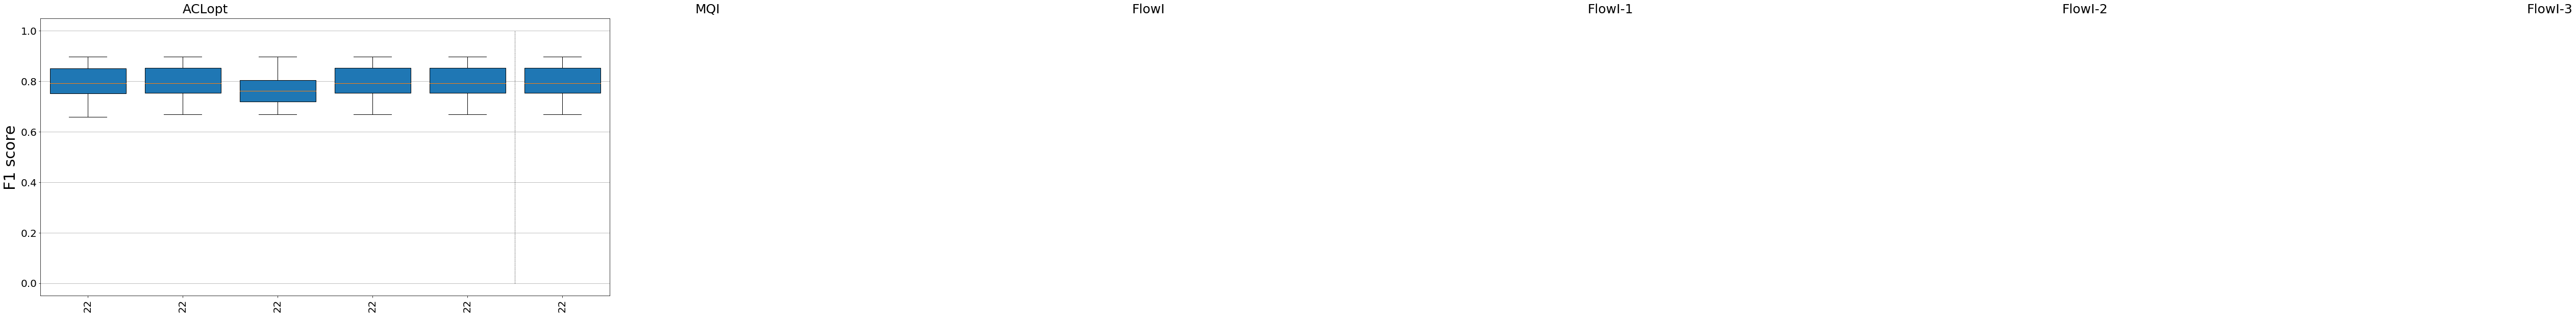

In [16]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_pre_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(2, 1.07, 'ACLopt', fontsize=25)
plt.text(7.4, 1.07, 'MQI', fontsize=25)
plt.text(12.0, 1.07, 'FlowI', fontsize=25)
plt.text(16.8, 1.07, 'FlowI-1', fontsize=25)
plt.text(21.8, 1.07, 'FlowI-2', fontsize=25)
plt.text(26.7, 1.07, 'FlowI-3', fontsize=25)


#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([5.5, 5.5], [0, 1], 'k:', linewidth=1)
plt.plot([10.45, 10.45], [0, 1], 'k:', linewidth=1)
plt.plot([15.45, 15.45], [0, 1], 'k:', linewidth=1)
plt.plot([20.45, 20.45], [0, 1], 'k:', linewidth=1)
plt.plot([25.5, 25.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_sfld_Optimal.png')

plt.show()

## Generate scatter plot for precision

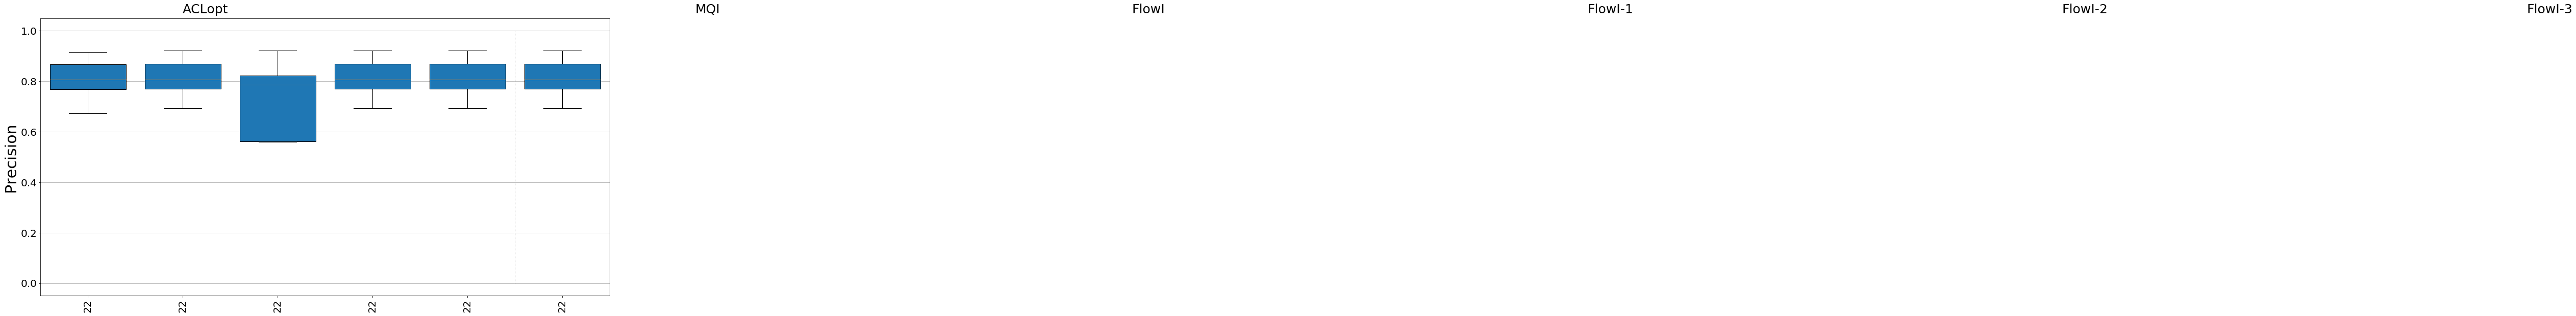

In [17]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(2, 1.07, 'ACLopt', fontsize=25)
plt.text(7.4, 1.07, 'MQI', fontsize=25)
plt.text(12.0, 1.07, 'FlowI', fontsize=25)
plt.text(16.8, 1.07, 'FlowI-1', fontsize=25)
plt.text(21.8, 1.07, 'FlowI-2', fontsize=25)
plt.text(26.7, 1.07, 'FlowI-3', fontsize=25)


#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([5.5, 5.5], [0, 1], 'k:', linewidth=1)
plt.plot([10.45, 10.45], [0, 1], 'k:', linewidth=1)
plt.plot([15.45, 15.45], [0, 1], 'k:', linewidth=1)
plt.plot([20.45, 20.45], [0, 1], 'k:', linewidth=1)
plt.plot([25.5, 25.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_sfld_Optimal.png')

plt.show()

## Generate scatter plot for recall

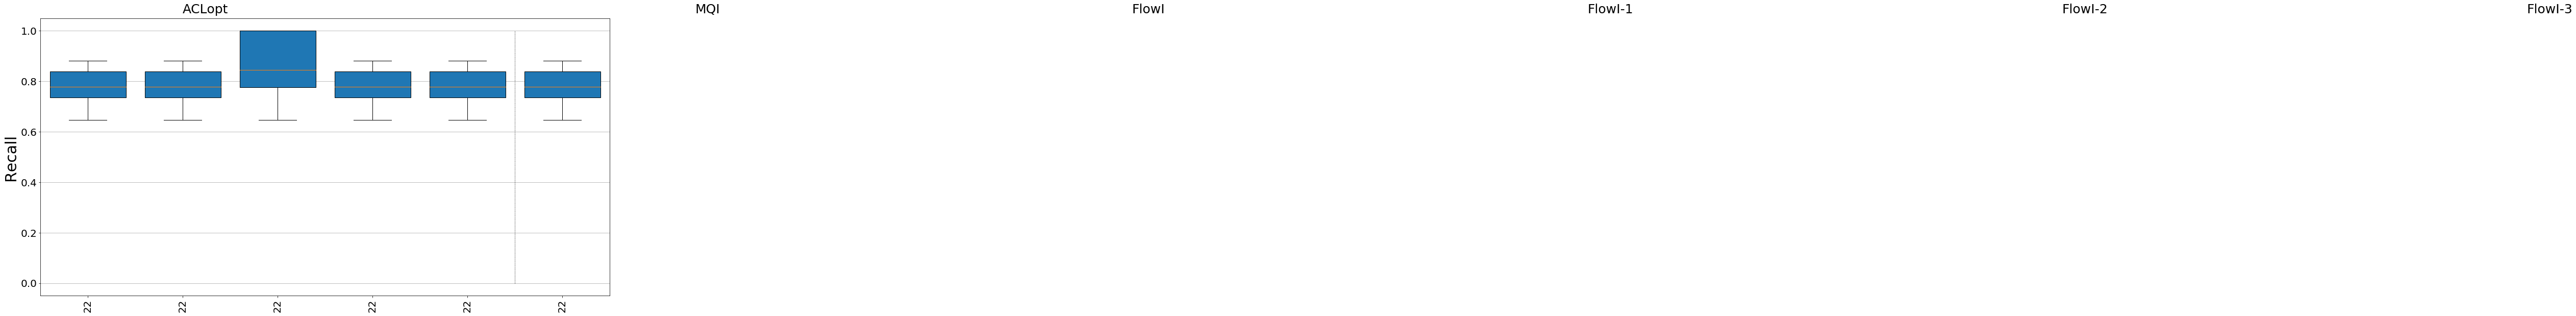

In [18]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_pre_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(2, 1.07, 'ACLopt', fontsize=25)
plt.text(7.4, 1.07, 'MQI', fontsize=25)
plt.text(12.0, 1.07, 'FlowI', fontsize=25)
plt.text(16.8, 1.07, 'FlowI-1', fontsize=25)
plt.text(21.8, 1.07, 'FlowI-2', fontsize=25)
plt.text(26.7, 1.07, 'FlowI-3', fontsize=25)


#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([5.5, 5.5], [0, 1], 'k:', linewidth=1)
plt.plot([10.45, 10.45], [0, 1], 'k:', linewidth=1)
plt.plot([15.45, 15.45], [0, 1], 'k:', linewidth=1)
plt.plot([20.45, 20.45], [0, 1], 'k:', linewidth=1)
plt.plot([25.5, 25.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_sfld_Optimal.png')

plt.show()

## Generate precision/recall and F1 scores

In [19]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
        temp_rec.append(recall_best_pre_acl[i,j])
        temp_f1.append(f1score_best_pre_acl[i,j])
        temp_conductance.append(external_best_cond_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))    
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")
    
print('Results for MQIopt')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        temp_conductance.append(external_cond_best_acl_flow_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))    
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowIopt')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        temp_conductance.append(external_cond_best_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))    
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-1opt')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
        temp_conductance.append(external_cond_best_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))    
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-2opt')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        temp_conductance.append(external_cond_best_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))    
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-3opt')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        temp_conductance.append(external_cond_best_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))    
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

Results for ACLopt
Feature: 22.0 Precision 0.8059033989266547 Recall 0.7772533777531001 F1 0.7918144439910864 Cond. 0.4392165478562424
Average precision 0.8059033989266547 Average recall 0.7772533777531001 Average F1 0.7918144439910864 Av. Cond. 0.4392165478562424
 
Results for MQIopt
Feature: 22.0 Precision 0.8063262272215396 Recall 0.7772533777531001 F1 0.7918144439910864 Cond. 0.45090160296829696
Average precision 0.8063262272215396 Average recall 0.7772533777531001 Average F1 0.7918144439910864 Av. Cond. 0.45090160296829696
 
Results for FlowIopt
Feature: 22.0 Precision 0.7868944537455024 Recall 0.8451169103584428 F1 0.7623382582052671 Cond. 0.43601117897682795
Average precision 0.7868944537455024 Average recall 0.8451169103584428 Average F1 0.7623382582052671 Av. Cond. 0.43601117897682795
 
Results for FlowI-1opt
Feature: 22.0 Precision 0.8063262272215396 Recall 0.7772533777531001 F1 0.7918144439910864 Cond. 0.45090160296829696
Average precision 0.8063262272215396 Average recall 0